In [401]:
# import block 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# for normalize
from sklearn.preprocessing import MinMaxScaler

# for balance data
from statistics import mode

# ETC 
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split

# plotting
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC


In [324]:
# Part 1: Data Extraction and Visualization

In [402]:
# Load
# import cell_states
file_path = '/Users/peytonhall/downloads/gene_expression/cell_states.txt'
cellStates = pd.read_csv(file_path, sep='\t', header=None)
cellStates = pd.to_numeric(cellStates[0])  # convert to series
cellStates = cellStates.values # convert to np array
cellStates

# import gene1
file_path = '/Users/peytonhall/downloads/gene_expression/gene1.txt'
gene1File = pd.read_csv(file_path, sep='\t', header=None)
gene1File = pd.to_numeric(gene1File[0])  # convert to series
gene1File = gene1File.values # convert to np array
gene1File

# import gene2
file_path = '/Users/peytonhall/downloads/gene_expression/gene2.txt'
gene2File = pd.read_csv(file_path, sep='\t', header=None)
gene2File = pd.to_numeric(gene2File[0])  # convert to series
gene2File = gene2File.values # convert to np array
gene2File

array([0.2915, 1.0242, 1.0102, ..., 1.1297, 0.8903, 1.081 ])

In [432]:
# Check file info
print("Cell States:", cellStates.shape)
print("Gene 1 Data:", gene1File.shape)
print("Gene 2 Data:", gene2File.shape)

Cell States: (1805,)
Gene 1 Data: (1805,)
Gene 2 Data: (1805,)


In [234]:
# Standardize Features

In [373]:
# make min-max normalization function
def normalizationFunct(shape):
    minShape = np.min(shape, axis=0)  # min 
    maxShape = np.max(shape, axis=0)  # max
    y = (shape - minShape) / (maxShape - minShape)
    return y

In [374]:
# normalize gene expression info 
# shape of both 1 and 2 normalized and pre is (1805,)
normalGene1 = normalizationFunct(gene1File)
normalGene2 = normalizationFunct(gene2File)

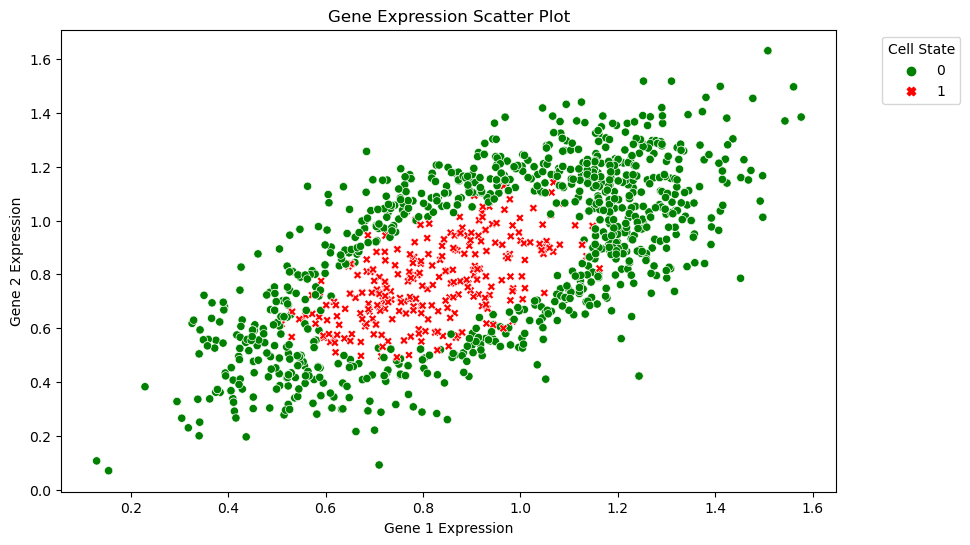

In [433]:
# visualize gene vs cell states
df = pd.DataFrame({
    'Gene1': gene1File.tolist(),
    'Gene2': gene2File.tolist(),
    'CellState': cellStates.tolist()
})

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Gene1', y='Gene2', hue='CellState', palette=['green', 'red'], style='CellState', legend='full')
plt.title('Gene Expression Scatter Plot')
plt.xlabel('Gene 1 Expression')
plt.ylabel('Gene 2 Expression')
plt.legend(title='Cell State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
"""
2. Use visualization to explore the relationship between the gene expression features and
the cell states. How is the data distributed? Are the classes balanced? What else do you
notice about the data? [0.5pt]

As for data distribution, data is clearly clustered, with cell state 1
being concentrated within the expression range of 0.2-0.7 for gene 1
and Cell state 1 being concentrated within the same rnage for gene 2 
expression. Cell state 0 is concentrated AROUND the cell state 1 cluster;
this clustering of both cell states suggests some imbalance in 
the data

"""

In [434]:
# splice dataframe into majority (0) and minority classes (1)
# [1805 rows x 3 columns]
print(df)

# majority
# [1507 rows x 3 columns]
df0 = df[df['CellState'] == 0]
print(df0)

# minority
# [298 rows x 3 columns]
df1 = df[df['CellState'] == 1]
print(df1)

       Gene1   Gene2  CellState
0     0.4128  0.2915          0
1     1.2991  1.0242          0
2     1.2214  1.0102          0
3     1.0570  0.6534          0
4     1.1207  0.7288          0
...      ...     ...        ...
1800  0.7224  0.7198          1
1801  0.3948  0.4226          0
1802  1.1552  1.1297          0
1803  1.0432  0.8903          1
1804  1.1933  1.0810          0

[1805 rows x 3 columns]
       Gene1   Gene2  CellState
0     0.4128  0.2915          0
1     1.2991  1.0242          0
2     1.2214  1.0102          0
3     1.0570  0.6534          0
4     1.1207  0.7288          0
...      ...     ...        ...
1798  0.7639  0.4238          0
1799  0.5451  0.3739          0
1801  0.3948  0.4226          0
1802  1.1552  1.1297          0
1804  1.1933  1.0810          0

[1507 rows x 3 columns]
       Gene1   Gene2  CellState
12    0.8929  0.7660          1
15    0.9483  0.9177          1
20    0.7650  0.6546          1
22    0.7087  0.7310          1
28    0.9137  0.9435  

In [435]:
# correct for any data imbalance by undersampling the majority (df0)

# Function: underSample()
# Parameters: df, column
# Returns: undersampled majority class
def underSample(df, column):
    majority = df[df[column] == 0]
    minority = df[df[column] == 1]
    
    majorityCount = len(majority)
    minorityCount = len(minority)
    

    # randomly undersample the majority class to count of minority
    randomMajSelect = np.random.choice(
        majority.index,
        size=minorityCount,
        replace=False
    )
    
    # make data frame of undersampled majority of 0s
    underMajorityRow = df.loc[randomMajSelect].copy()
    
    # combine undersampled 0s with all minority list of 1s
    undersampleData = pd.concat([underMajorityRow, minority])
    
    return undersampleData

In [436]:
# make undersampled dataframe
undersampledDf = underSample(df, 'CellState')
# 596 rows × 3 columns

In [437]:
# Cell state DataFrame for y (target)
y = undersampledDf['CellState'].copy()  # Use the CellState column
print("Shape of y (target):", y.shape)  # Should be (596,)

# Gene DataFrame for X (features)
X = undersampledDf.iloc[:, :2].copy()  # Copy the first two columns (Gene1, Gene2)
print("Shape of X (features):", X.shape)  # Should be (596, 2)

# Check the shapes again
print("Shape of X (features):", X.shape)  
print("Shape of y (target):", y.shape)  


Shape of y (target): (596,)
Shape of X (features): (596, 2)
Shape of X (features): (596, 2)
Shape of y (target): (596,)


In [ ]:
'''
4. Based on your observations, explain the following: [0.5pt]
● Do you expect that a logistic regression model would fit the data well?
● How about a support vector machine classifier (SVC)?
● Does the choice of kernel matter?

Based on my observations, I don't expect a logistic regression model
to fit the data well before undersampling due to the strong imbalance
in the data. The clusters appear to be strongly
clustered with some overlap, with a non-linear clustering pattern, 
so logistic regression may find difficulty with establishing a
decision boundary. 

A SVC may perform better since the clusters are pretty well defined. 
Since SVC uses different kernels and is able to handle non-linear data, 
this may work but there is still overlap that might be an issue. 

I think the choice of Kernel would matter. Out of linear, polynomial, 
and radial basis function (RBF), I feel a radial basis function may
work the best since the data is already clustered strongly in a 
non-linear, radial distribution around a gene expression value of 0.5. 

'''

In [ ]:
# Part 2: Linear Classifier

In [438]:
# Function: logisticRegressionReg()
# Parameters: X, y 
# Returns: metrics (AUROC, accuracy, precision, recall, and F1-score)
# L2 reg parameter C is set to [0.001, 0.01, 0.1, 1, 10, 1e5]

def logisticRegressionReg(X, y):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    # logistic regression model with L2 regularization
    logistic_model = LogisticRegression(penalty='l2', max_iter=5000, solver='lbfgs')

    
    
    # define the parameter grid for C
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

    
    # Set up GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, 
                               scoring='roc_auc', cv=5, verbose=1)
    # fit model with gridSearch
    grid_search.fit(X_train, y_train)

    
    # get the best model from grid search
    best_model = grid_search.best_estimator_
    
    # use best model to predict on test
    y_pred = best_model.predict(X_test)

    # get probabilities for metrics
    y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

    # metrics
    metrics_dict = {
        "Accuracy": metrics.accuracy_score(y_test, y_pred),
        "Precision": metrics.precision_score(y_test, y_pred),
        "Recall": metrics.recall_score(y_test, y_pred),
        "F1-score": metrics.f1_score(y_test, y_pred),
        "AUROC": metrics.roc_auc_score(y_test, y_proba)
    }

    return metrics_dict

In [439]:
# Function: logisticRegressionReg()
# Parameters: X, y 
# Returns: metrics (AUROC, accuracy, precision, recall, and F1-score)
# NO regression parameter

def logisticRegressionNoReg(X, y):
    # split the data into training and testing sets (80%-20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Set up the logistic regression model without regularization
    logistic_model = LogisticRegression(penalty='none', max_iter=5000, solver='lbfgs')
    
    
    # scale inside to prevent data leak
    scaler = MinMaxScaler()
    
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    
    X_test = scaler.transform(X_test)

    # Fit the model
    logistic_model.fit(X_train, y_train)

    # Use the model to predict on test
    y_pred = logistic_model.predict(X_test)

    # Get probabilities for metrics
    y_proba = logistic_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

    # Evaluate with metrics
    metrics_dict = {
        "Accuracy": metrics.accuracy_score(y_test, y_pred),
        "Precision": metrics.precision_score(y_test, y_pred),
        "Recall": metrics.recall_score(y_test, y_pred),
        "F1-score": metrics.f1_score(y_test, y_pred),
        "AUROC": metrics.roc_auc_score(y_test, y_proba)
    }

    return metrics_dict

In [440]:
#  get metrics for model WITH regularization
outputReg = logisticRegressionReg(X, y)  
print("Metrics with Regularization:")
print(outputReg)
# this one did BAD

#  get metrics for model WITHOUT regularization
outputNoReg = logisticRegressionNoReg(X, y)  
print("Metrics without Regularization:")
print(outputNoReg)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


AttributeError: 'dict' object has no attribute 'accuracy_score'

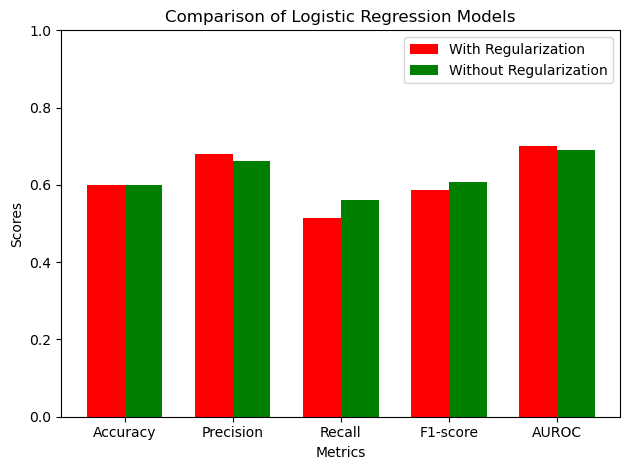

In [412]:
# Make a barplot comparing the validation metrics (AUROC, accuracy, precision, recall, and F1-score) on the test set for each model.
# Function: barPlot()
# Parameters: metrics_reg, metrics_no_reg
# Returns: a bar plot comparing metrics between two models

def barPlot(metrics_reg, metrics_no_reg):
    metricsNames = list(metrics_reg.keys())
    metricsValues = [list(metrics_reg.values()), list(metrics_no_reg.values())]

    bar_width = 0.35
    x = np.arange(len(metricsNames))

    # plot bars for regularized and non-regularized metrics
    plt.bar(x - bar_width/2, metricsValues[0], width=bar_width, label='With Regularization', color='red')
    plt.bar(x + bar_width/2, metricsValues[1], width=bar_width, label='Without Regularization', color='green')

    # label axes and the plot
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Comparison of Logistic Regression Models')
    plt.xticks(x, metricsNames)
    plt.ylim(0, 1) 
    plt.legend()

    plt.tight_layout()
    plt.show()

# bar plot
barPlot(outputReg, outputNoReg)

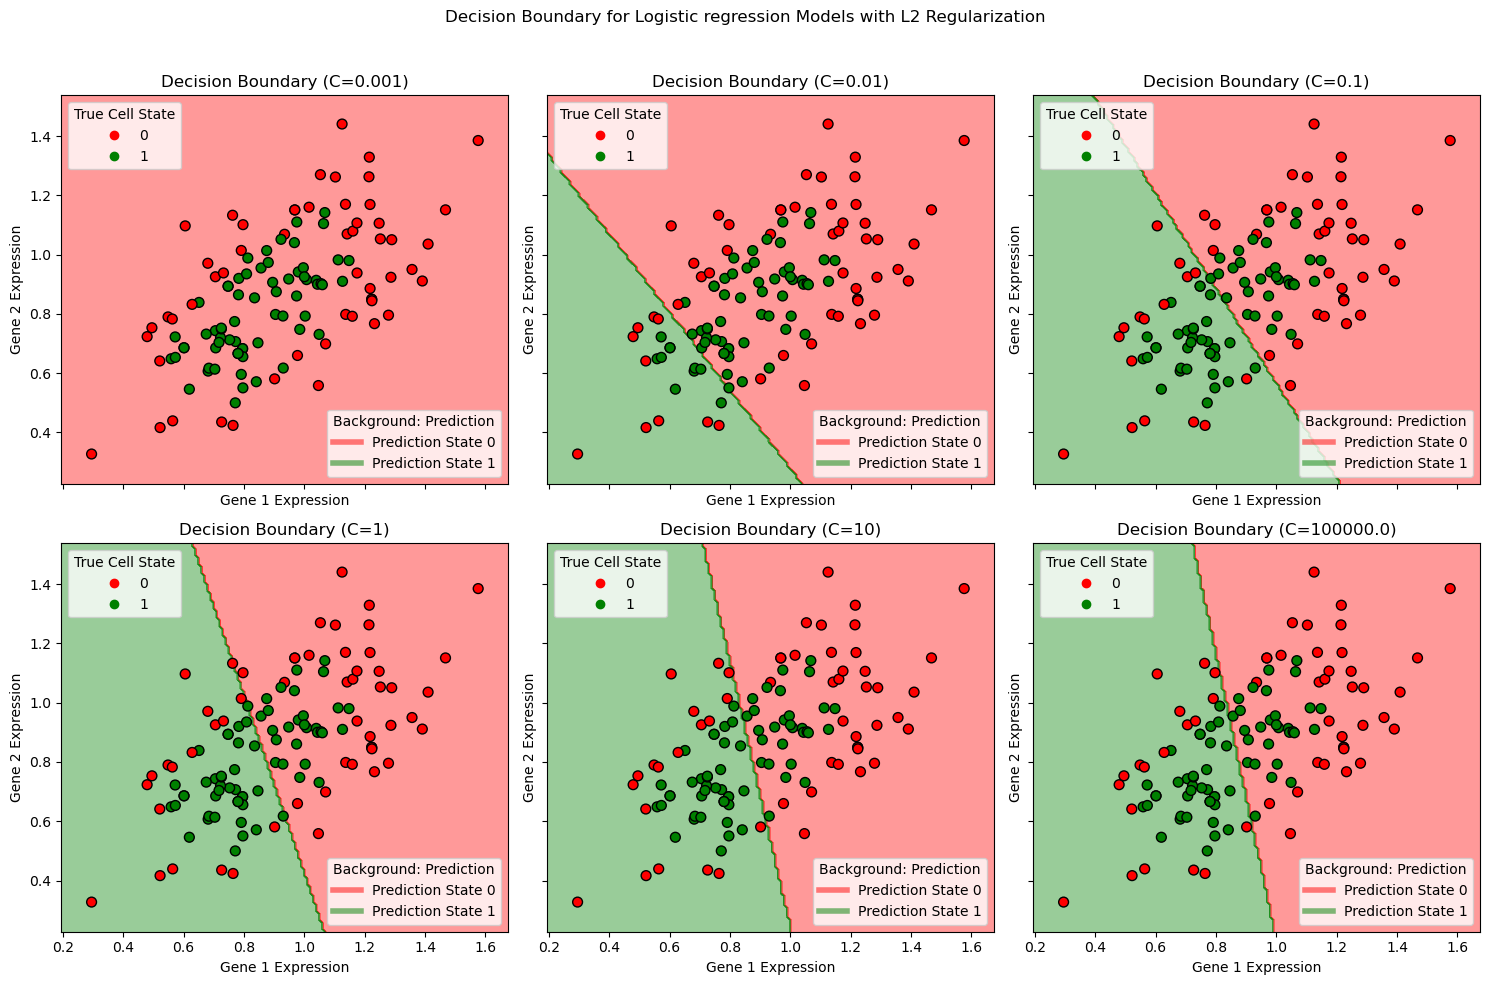

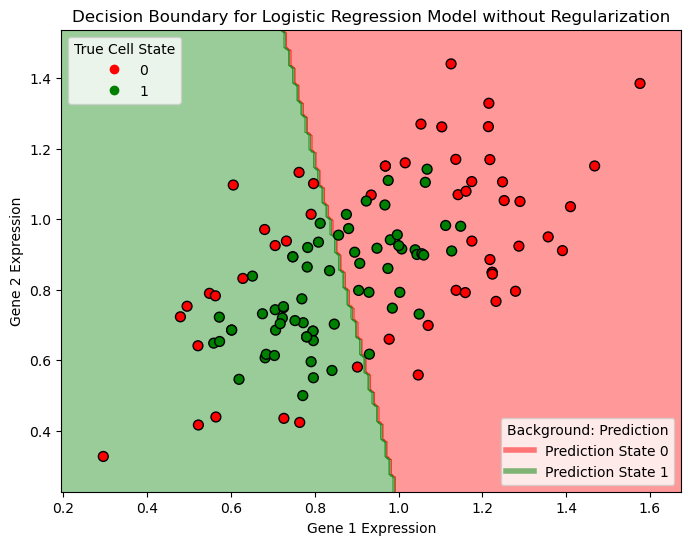

In [413]:
# Function: decisionBoundary()
# Parameters: X_train, y_train, model, title, ax
# Returns: decision boundary plot

def decisionBoundary(X_train, y_train, model, title, ax):
    # Create meshgrid for the features
    x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
    y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict the class for each point in the mesh grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)
    
    # Create contour plot for decision boundaries
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(['red', 'green']))

    # Overlay scatter plot for the training data
    scatter = ax.scatter(X_train[:, 0], X_train[:, 1], 
                         c=y_train, cmap=ListedColormap(['red', 'green']), 
                         edgecolor='k', s=50)

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('Gene 1 Expression')
    ax.set_ylabel('Gene 2 Expression')

    # Add legend for true cell states
    legend1 = ax.legend(*scatter.legend_elements(), title="True Cell State", loc='upper left')
    ax.add_artist(legend1)

    # Add legend for predictions
    handles = [plt.Line2D([0], [0], color='red', alpha=0.5, lw=4, label='Prediction State 0'),
               plt.Line2D([0], [0], color='green', alpha=0.5, lw=4, label='Prediction State 1')]
    ax.legend(handles=handles, title="Background: Prediction", loc='lower right')

# Define the C values for L2 regularization
grid = [0.001, 0.01, 0.1, 1, 10, 1e5]

# Prepare the subplot figure for L2 regularization
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.ravel()

# Create a list to hold the models for L2 regularization
L2_models = []

# Train models with L2 regularization
for C in grid:
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.ravel(), test_size=0.2, random_state=0)
    model = LogisticRegression(penalty='l2', C=C, max_iter=5000, solver='lbfgs')
    model.fit(X_train, y_train)
    L2_models.append(model)

# Plot decision boundaries for each L2 regularized model
for i, model in enumerate(L2_models):
    decisionBoundary(X_test, y_test, model, f"Decision Boundary (C={grid[i]})", axes[i])

# Add main title for L2 regularization plots
plt.suptitle("Decision Boundary for Logistic regression Models with L2 Regularization")
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for title
plt.show()

# Now create a separate plot for the model without regularization
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.ravel(), test_size=0.2, random_state=0)
model_no_reg = LogisticRegression(penalty='none', max_iter=5000, solver='lbfgs')
model_no_reg.fit(X_train, y_train)

# Create a new figure for the model without regularization
plt.figure(figsize=(8, 6))
decisionBoundary(X_test, y_test, model_no_reg, "Decision Boundary without Regularization", plt.gca())
plt.title("Decision Boundary for Logistic Regression Model without Regularization")
plt.show()


In [ ]:
'''
3. Explain: [0.5pt]

Regularization, such as C=10^5, 10, 1, and even 0.1 allows the model to closely fit the 
training data, resulting in more detailed decision boundaries to accomodate more training data. 
This might result in overfitting though. 

A regularization such as 0.001 or 0.01 makes the model simpler, resulting in simpler decision 
boundaries that might not capture training data well. This can result in underfitting since these 
regularizations might be restricting the model. 

I think they all performed poorly due to the linear nature of the decision boundary trying to work 
with the clustered radial data. If I had to pick one, I'd say a moderate level of between 
0.1 - 1 resulted in a better fit than the other more extreme levels. They're probably limited by 
the clustered data, even after undersampling since the data is non-linear in distribution. 
'''

In [ ]:
# Part 3: Linear SVM Classifier

In [414]:
# Function: linearSVC()
# Parameters: x, y
# Returns: metrics from linear SVC classifier

def linearSVC(X, y):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # define the parameter grid for C
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 1e5]}
    
    # scale inside to prevent data leak
    scaler = MinMaxScaler()
    
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    
    X_test = scaler.transform(X_test)
    
    # make a linear SVM Classifier
    clf = svm.SVC(kernel='linear', probability=True)  # Set probability=True to use predict_proba

    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')

    # fit the model using grid search
    grid_search.fit(X_train, y_train)

    # use the best model to predict on test data
    y_pred = grid_search.predict(X_test)

    # get probabilities for metrics
    y_proba = grid_search.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

    # get metrics
    metrics_dict = {
        "Accuracy": metrics.accuracy_score(y_test, y_pred),
        "Precision": metrics.precision_score(y_test, y_pred),
        "Recall": metrics.recall_score(y_test, y_pred),
        "F1-score": metrics.f1_score(y_test, y_pred),
        "AUROC": metrics.roc_auc_score(y_test, y_proba)
    }

    return metrics_dict

In [415]:
# 1. Train a linear SVM Classifier:
# get linear svm output
outputSVM = linearSVC(X, y)  

In [416]:
# make dict to hold the metricss
metrics_summary = {
    "Metrics": ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUROC'],
    "Logistic Regression (L2)": [
        outputReg["Accuracy"],
        outputReg["Precision"],
        outputReg["Recall"],
        outputReg["F1-score"],
        outputReg["AUROC"]
    ],
    "Logistic Regression (No Reg)": [
        outputNoReg["Accuracy"],
        outputNoReg["Precision"],
        outputNoReg["Recall"],
        outputNoReg["F1-score"],
        outputNoReg["AUROC"]
    ],
    "Linear SVM": [
        outputSVM["Accuracy"],
        outputSVM["Precision"],
        outputSVM["Recall"],
        outputSVM["F1-score"],
        outputSVM["AUROC"]
    ]
}

In [417]:
# need to convert to df
metricsDf = pd.DataFrame(metrics_summary)
metricsDf.set_index('Metrics', inplace=True)

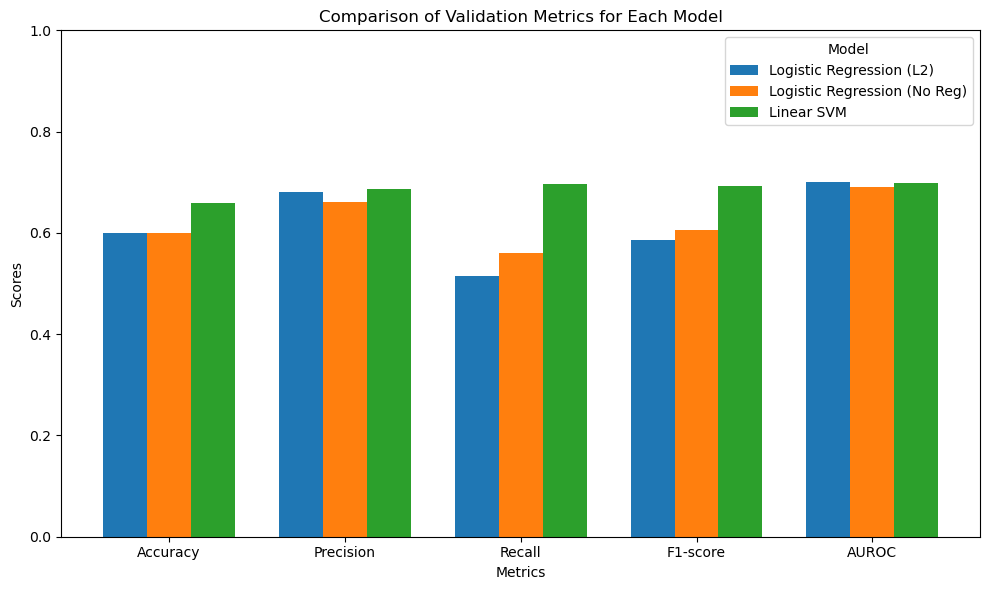

In [418]:
# bar plot
bar_width = 0.25
x = np.arange(len(metricsDf.index))

plt.figure(figsize=(10, 6))

# loop bars for each model
for i, column in enumerate(metricsDf.columns):
    plt.bar(x + (i * bar_width), metricsDf[column], width=bar_width, label=column)

# labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Validation Metrics for Each Model')
plt.xticks(x + bar_width, metricsDf.index)
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.legend(title='Model')
plt.tight_layout()
plt.show()

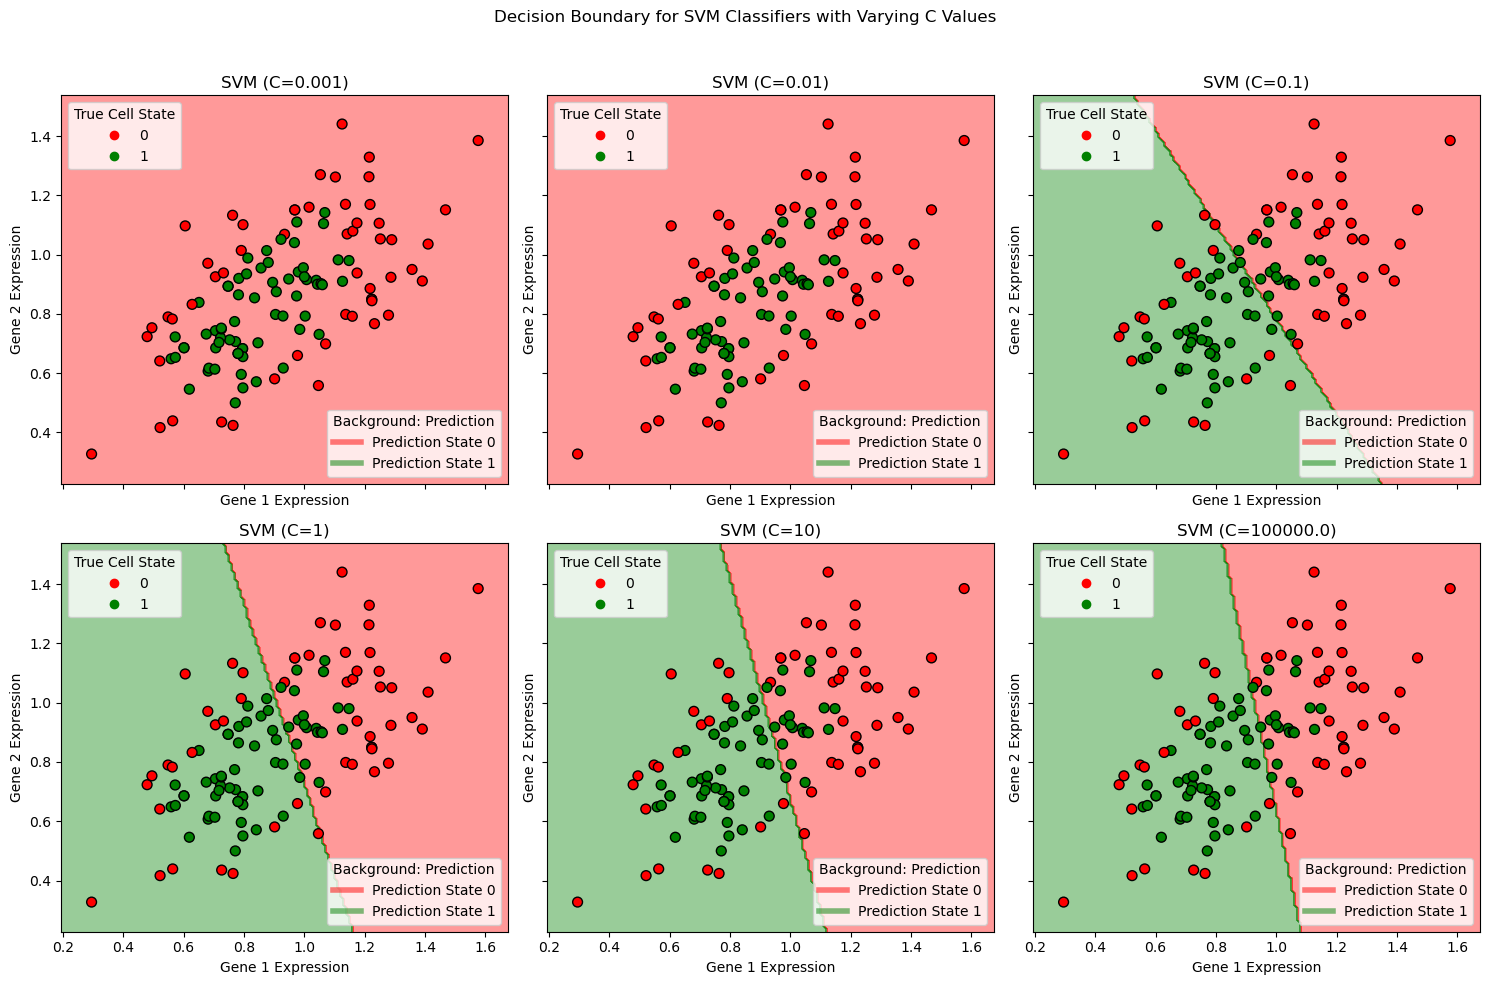

In [419]:
# 2. Visualize Decision Boundary: 

# def parameter grid for C
param_grid = [0.001, 0.01, 0.1, 1, 10, 1e5]

# prep the subplot figure for SVM
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.ravel()

# train models with varying C values
for i, C in enumerate(param_grid):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = SVC(kernel='linear', C=C, probability=True)  # Set probability=True to get probabilities
    model.fit(X_train, y_train)

    # decision boundary for each model
    decisionBoundary(X_test.values, y_test, model, f"SVM (C={C})", axes[i])

# title for SVM plots/formatting
plt.suptitle("Decision Boundary for SVM Classifiers with Varying C Values")
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for title
plt.show()


In [ ]:
'''
2. Explain: Does the linear SVM model perform better than the logistic regression? Why or
why not? [0.5pt]

The linear SVM model performs better than the logistic regression 
because of the increased flexibility for multiple-dimension data such as this data. 

Also SVMs may be more robust/accomodating of outiers since SVM focuses on data closest to 
decision boundaries (support vectors), whereas logistic regression just focuses on 
minimizing the overall error across all points making it more sensitive to noise/outliers.

'''

In [ ]:
# Part 4: Kernel SVM Classifiers

In [429]:
# Function: trainSvmWithKernel()
# Parameters: X, y, kernel
# Returns: model and metrics 

def trainSvmWithKernel(X, y, kernel, C=1.0, degree=None):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # make SVM Classifier
    if kernel == 'linear':
        model = svm.SVC(kernel='linear', C=C, probability=True)
    elif kernel == 'poly':
        model = svm.SVC(kernel='poly', C=C, degree=degree, probability=True)
    elif kernel == 'rbf':
        model = svm.SVC(kernel='rbf', C=C, probability=True)
    else:
        raise ValueError("Unsupported kernel type")

    # train the model
    model.fit(X_train, y_train)

    # predict response for test dataset
    y_pred = model.predict(X_test)

    # get probabilities for metrics
    y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

    # metrics
    metrics_dict = {
        "Accuracy": metrics.accuracy_score(y_test, y_pred),
        "Precision": metrics.precision_score(y_test, y_pred),
        "Recall": metrics.recall_score(y_test, y_pred),
        "F1-score": metrics.f1_score(y_test, y_pred),
        "AUROC": metrics.roc_auc_score(y_test, y_proba)
    }

    return model, metrics_dict

In [430]:
# def parameters for training
kernels = ['linear', 'poly', 'rbf']
C = 1.0  # used regularization parameter

In [431]:
# empty dict to hold 
models = {}
metrics_results = {}
# Train models for each kernel
for kernel in kernels:
    if kernel == 'poly':
        model, metrics_results[kernel] = trainSvmWithKernel(X, y, kernel, C=C, degree=3)
    else:
        model, metrics_results[kernel] = trainSvmWithKernel(X, y, kernel, C=C)
    models[kernel] = model

AttributeError: 'dict' object has no attribute 'accuracy_score'

In [423]:
# print metrics for each model
for kernel, metrics in metrics_results.items():
    print(f"Metrics for {kernel} kernel:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()  

Metrics for linear kernel:
Accuracy: 0.6583333333333333
Precision: 0.6865671641791045
Recall: 0.696969696969697
F1-score: 0.6917293233082707
AUROC: 0.6982323232323233

Metrics for poly kernel:
Accuracy: 0.825
Precision: 0.835820895522388
Recall: 0.8484848484848485
F1-score: 0.8421052631578948
AUROC: 0.8726150392817059

Metrics for rbf kernel:
Accuracy: 0.9
Precision: 0.921875
Recall: 0.8939393939393939
F1-score: 0.9076923076923077
AUROC: 0.9778338945005612



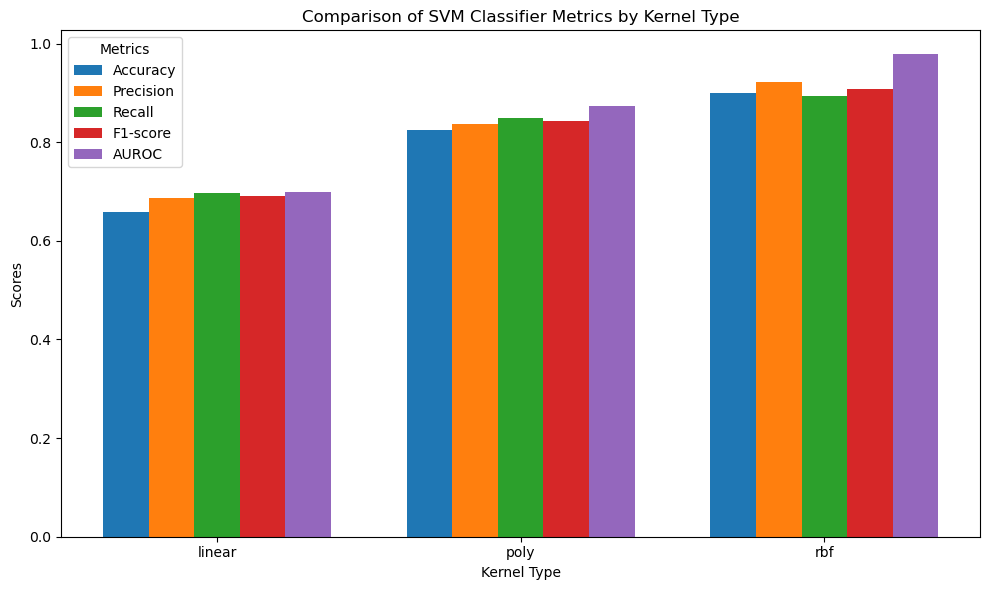

In [424]:
# prep data for plotting
metricsNames = list(metrics_results.values())[0].keys()  # Get metric names
numMetrics = len(metricsNames)
numKernels = len(kernels)

# make a bar plot for each metric
x = np.arange(numKernels)  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# loop bars for each metric
for i, metric in enumerate(metricsNames):
    metric_values = [metrics_results[kernel][metric] for kernel in kernels]
    ax.bar(x + i * width, metric_values, width, label=metric)

# format labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Kernel Type')
ax.set_ylabel('Scores')
ax.set_title('Comparison of SVM Classifier Metrics by Kernel Type')
ax.set_xticks(x + width * (numMetrics - 1) / 2)
ax.set_xticklabels(kernels)
ax.legend(title='Metrics')

# plot
plt.tight_layout()
plt.show()

In [425]:
# to avoid issues back to array
X = np.array(X)  

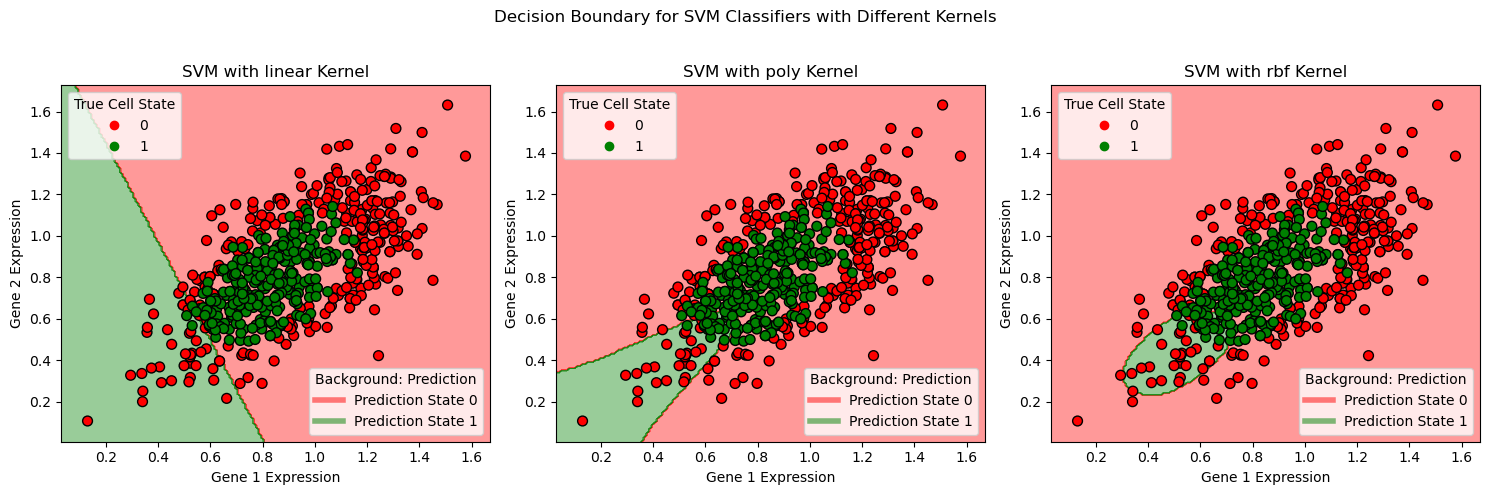

In [428]:
# 2. Visualize Decision Boundary:
# prep the subplot figure for SVM
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.ravel()

# list of kernels corresponding to the trained models
kernels = ['linear', 'poly', 'rbf']

# loop through the kernels and plot decision boundaries
for i, kernel in enumerate(kernels):
    decisionBoundary(X, y, models[kernel], f"SVM with {kernel} Kernel", axes[i])

# titless
plt.suptitle("Decision Boundary for SVM Classifiers with Different Kernels")
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

In [427]:
'''
3. Explain: [1pt]

Linear kernel creates a linear boundary that performs better than the logistic regression 
because of the increased flexibility for multiple-dimension data. Although this performs 
better than other classifiers, it performs worse than other SVM kernels for this type of 
data since the data is not linear, but the decision boundary is. 

Poly kernel is better than linear kernel since better captures non-linear relationships. It 
is better for fitting curved data because it considers interactions between gene features 
by calculating  polynomial combination of features that help in creating a much more 
flexible decision boundary than a linear one. 

The radial basis function kernel performs so well in this particular case because the 
distribution of the data is radial. 
'''

'\n3. Explain: [1pt]\n\nLinear kernel creates a linear boundary that performs better than the logistic regression \nbecause of the increased flexibility for multiple-dimension data. Although this performs \nbetter than other classifiers, it performs worse than other SVM kernels for this type of \ndata since the data is not linear, but the decision boundary is. \n\nPoly kernel is better than linear kernel since better captures non-linear relationships. It \nis better for fitting curved data because it considers interactions between gene features \nby calculating  polynomial combination of features that help in creating a much more \nflexible decision boundary than a linear one. \n\nThe radial basis function kernel performs so well in this particular case because the \ndistribution of the data is radial. \n'